In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image
from typing import *

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

from patch_optimizers.utils import *
from patch_optimizers.sliding_window_optimizer import SlidingWindowOptimizer
from patch_optimizers.simulated_annealing_optimizer import SimulatedAnnealingOptimizer

## Load model

In [2]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

## Load dataset

In [3]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=8)
test_loader_single = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

train_set = Dataset(x_train, y_train)
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=False, num_workers=8)
train_loader_single = data.DataLoader(dataset=train_set, batch_size=1, shuffle=False, num_workers=1)

C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Cost function 

Model output is `(x, y, z, theta)`, where

* x - up down (depth, distance), between 0 and 3 m
* y - left right
* z - height
* theta - angle (not very reliable), 0 when person is facing the drone, 180 (in radians) when the person looks in the opposite direction


## SlidingWindowOptimizer
Greedy selection

In [13]:
def run_sliding_window_optimizer_and_print_results(
    img,
    ground_truth,
    sliding_window_optimizer,
):
    best_cost, optimal_greedy_points = sliding_window_optimizer.run(
        img=img,
        ground_truth=ground_truth,
    )

    print("\n\n ======= \n\n")
    print(f"Results for stride = {stride}")
    print("Best cost for a single point", best_cost)
    print(f"Cost on raw image: {sliding_window_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])}")
    print(f"Prediction on raw: {model(img)[0]}")
    print(optimal_greedy_points)

    for x, y in optimal_greedy_points:
        apply_path(
            img=img[0][0].numpy(),
            x=x,
            y=y,
            size=10,
        )

    print(
        "Total cost for all points: ", 
        sliding_window_optimizer._cost_f(model(img), next(iter(test_loader_single))[1])
    )
    print(f"Prediction after patches: {model(img)[0]}")
    plt.imshow(img[0][0].numpy(), cmap="gray")
    plt.title(f"Stride = {stride}")
    plt.show()





Results for stride = 5
Best cost for a single point 1.6510531
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 55), (15, 60), (25, 55)]
Total cost for all points:  1.3048989
Prediction after patches: tensor([[1.5721]], grad_fn=<UnsqueezeBackward0>)


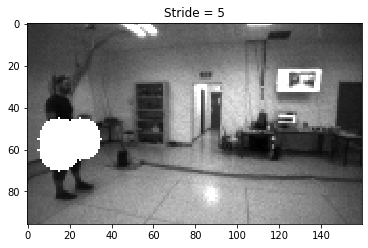





Results for stride = 10
Best cost for a single point 1.2669193
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(20, 80), (30, 80), (10, 60)]
Total cost for all points:  0.99663043
Prediction after patches: tensor([[1.7161]], grad_fn=<UnsqueezeBackward0>)


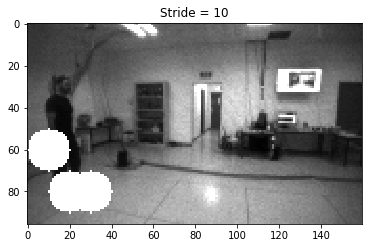





Results for stride = 15
Best cost for a single point 1.5004641
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(15, 60), (30, 75), (45, 75)]
Total cost for all points:  2.497519
Prediction after patches: tensor([[1.1340]], grad_fn=<UnsqueezeBackward0>)


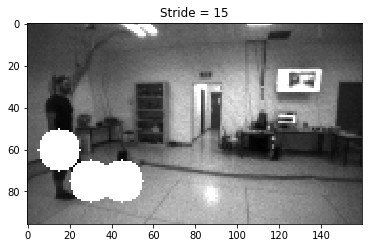

Wall time: 28.4 s


In [14]:
%%time

for stride in (5, 10, 15):
    img = next(iter(test_loader_single))[0]
    sliding_window_optimizer = SlidingWindowOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        k_dots=3,
        dot_size=10,
        stride=stride,
    )
    run_sliding_window_optimizer_and_print_results(
        img=img,
        ground_truth=next(iter(test_loader_single))[1],
        sliding_window_optimizer=sliding_window_optimizer,
    )

### Do the opposite - try to find dots that help the model to do a correct prediction





Results for stride = 5
Best cost for a single point 0
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(95, 55), (95, 30), (95, 35)]
Total cost for all points:  0.0001921323
Prediction after patches: tensor([[2.7283]], grad_fn=<UnsqueezeBackward0>)


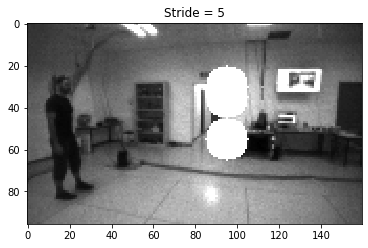





Results for stride = 10
Best cost for a single point 0
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(90, 60), (30, 30), (60, 50)]
Total cost for all points:  0.05049629
Prediction after patches: tensor([[2.4897]], grad_fn=<UnsqueezeBackward0>)


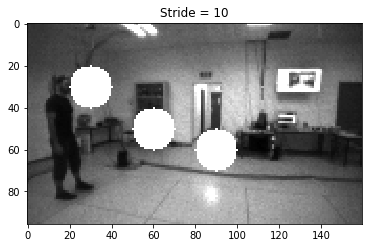





Results for stride = 15
Best cost for a single point 0
Cost on raw image: 0.23846887052059174
Prediction on raw: tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>)
[(90, 60), (30, 30), (0, 45)]
Total cost for all points:  0.06360683
Prediction after patches: tensor([[2.4622]], grad_fn=<UnsqueezeBackward0>)


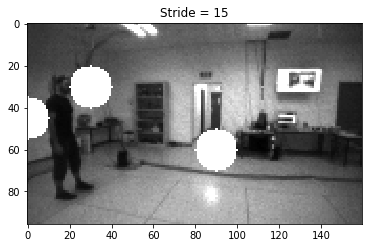

Wall time: 26.8 s


In [15]:
%%time

for stride in (5, 10, 15):
    img = next(iter(test_loader_single))[0]
    sliding_window_optimizer = SlidingWindowOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        k_dots=3,
        dot_size=10,
        stride=stride,
        find_dots_that_fix_prediction=True,
    )
    run_sliding_window_optimizer_and_print_results(
        img=img,
        ground_truth=next(iter(test_loader_single))[1],
        sliding_window_optimizer=sliding_window_optimizer,
    )

## Simulated annealing

### Custom implementation

as `scipy.optimize.basinhopping` did not work

In [4]:
simulated_anneling_optimizer = SimulatedAnnealingOptimizer(
    x0=(110, 20),
    stride=10,
    max_iters=100,
    dataloader=test_loader_single,
    model=model,
    cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
)

Simulated Annealing: 100%|███████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


Steps: 100
Best solution: (35, 63)
Best cost: -1.452614665031433
Number of good jumps: 46
Number of random jumps: 53
Raw cost: -0.23846887052059174
Ground truth: tensor([[2.7144, 1.6457, 0.4579, 0.9933]])
Prediction on raw: [2.2261, 1.5141, 0.4459, 0.5643]
Prediction with patch: [1.5091, 1.199, 0.4005, 0.3151]


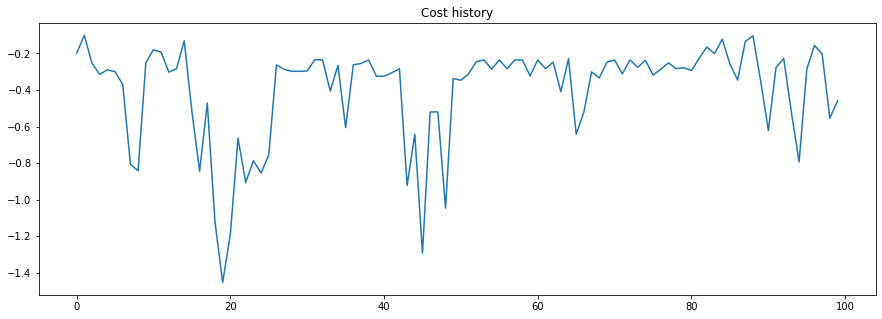

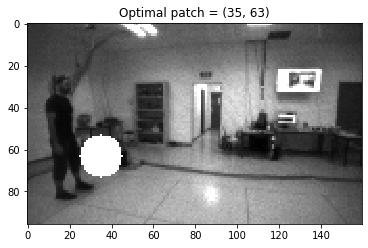

In [5]:
simulated_anneling_optimizer.run()

### TODO: jumping visualization